In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from time import time
from functions import utils
import os.path as path

## User input

In [2]:
sample_file = utils.gui_fname().decode("utf-8")
background_filename = utils.gui_fname().decode("utf-8")
tokens = sample_file.split('/')
base = path.basename(sample_file)
abs_dir = path.dirname(sample_file)
prefix = base.split('.')[0]
sample_prefix = abs_dir + '/' + prefix
print("Sample: \n%s" %sample_file)
print("Background: \n%s" %background_filename)

Sample: 
C:/Data/Ashlee/20190301_immobilized_SWR1/5nM_SWR1_1nM_C1-4/m190301_231841_42131_c000473112559900001500000112312160_s1_p0.metadata.xml
Background: 
C:/Data/Ashlee/20190301_immobilized_SWR1/PIB_blank/m190301_210723_42131_c000473092559900001500000112312130_s1_p0_background.csv


In [3]:
color1 = 0
color2 = 2

leakage = np.zeros((4, 4))
background = [0, 0, 0, 0]
gamma = np.ones((4,))
leakage = np.array([[0.        , 0.48921841, 0.09134705, 0.02373513],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.3349036856391455],
       [0.        , 0.        , 0.        , 0.        ]])
gamma = np.ones((4,))
gamma[2] = 1.3709926961993117

## Load data

In [4]:
start = time()
trc_filename = sample_prefix + '.trc.h5'
mcd_filename = sample_prefix + '.mcd.h5'
upd_filename = sample_prefix + '.upd.h5'
meta_filename = sample_prefix + '.metadata.xml'

trc_file = h5py.File(trc_filename, 'r')
mcd_file = h5py.File(mcd_filename, 'r')
upd_file = h5py.File(upd_filename, 'r')

# Load data in trace file
dset = trc_file['TraceData']
raw_traces = dset['Traces']
decode = dset['Codec']['Decode']
n_traces = raw_traces.shape[0]
n_frames = raw_traces.shape[2]
decode_array = np.array(decode)

# Load data in upd file
upd_TD = upd_file['TraceData']
hole_xy_plot = upd_TD['HoleXYPlot'] # (x,y) coordinates for each well
hole_status = upd_TD['HoleStatus'] # fiducials

# Extract frame rate from metadata
meta_tree = ET.parse(meta_filename)
root = meta_tree.getroot()
for keyval in root.iter('{http://pacificbiosciences.com/PAP/Metadata.xsd}KeyValue'):
    if keyval.attrib['key'] == 'MovieFPS':
        fps = int(keyval.text)
        frame_rate = 1.0/fps # seconds
        break

# For plotting
time_axis = np.arange(n_frames)*frame_rate
colors = ['green', (0, 1, 0), 'red', 'orange']
# lasers = ['Cy3', 'Cy3.5', 'Cy5', 'Cy5.5']
lasers = ['Cy3', 'Cy5']

bg_file = open(background_filename, "rb")
bg = np.loadtxt(bg_file, delimiter=",")

print("Time passed: " + str(time() - start))

Time passed: 1.1582674980163574


## View a trace

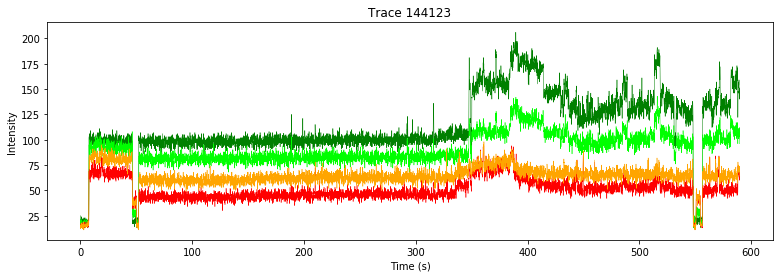

In [317]:
plt.figure(figsize=(13, 4))
traceID = np.random.randint(0, n_traces)
utils.plot_one_trace(raw_traces, traceID, time_axis, range(0, 5899), colors)

In [45]:
start_frame = 600
end_frame = 5400

## Preprocessing

In [46]:
foi = range(start_frame, end_frame) # frames of interest
n_frames = len(foi)

# first_10_frames = np.zeros((n_traces, 4, 10), dtype=np.uint8)
first_10_frames = np.array(raw_traces[:, :, range(start_frame, start_frame + 10)], dtype=np.uint8)

corrected_f10f = np.zeros(first_10_frames.shape)
for i in range(n_traces):
    corrected_f10f[i] = decode_array[first_10_frames[i]]

avg_intens = np.mean(corrected_f10f, axis=2)
avg_intens_bgs = np.zeros((n_traces, 4))

for i in range(n_traces):
    new_intens = avg_intens[i] - bg[i]
    avg_intens_bgs[i]= new_intens

In [51]:
mid = int((start_frame + end_frame) / 2)
mid_10_frames = np.array(raw_traces[:, :, range(mid, mid + 10)], dtype=np.uint8)

corrected_m10f = np.zeros(mid_10_frames.shape)
for i in range(n_traces):
    corrected_m10f[i] = decode_array[mid_10_frames[i]]

avg_intens_mid = np.mean(corrected_m10f, axis=2)
avg_intens_bgs_mid = np.zeros((n_traces, 4))

for i in range(n_traces):
    new_intens = avg_intens_mid[i] - bg[i]
    avg_intens_bgs_mid[i]= new_intens

In [319]:
last_10_frames = np.array(raw_traces[:, :, range(end_frame - 10, end_frame)], dtype=np.uint8)

corrected_l10f = np.zeros(mid_10_frames.shape)
for i in range(n_traces):
    corrected_l10f[i] = decode_array[last_10_frames[i]]

avg_intens_last = np.mean(corrected_l10f, axis=2)
avg_intens_bgs_last = np.zeros((n_traces, 4))

for i in range(n_traces):
    new_intens = avg_intens_last[i] - bg[i]
    avg_intens_bgs_last[i]= new_intens

In [ ]:
# avg_intens_bgs2 = np.array(avg_intens_bgs)

# for i in range(n_traces):
#     avg_intens_bgs2[i, 0]= avg_intens_bgs[i, 0] + 35

In [ ]:
# bg[:, 0] = bg[:, 0] + 35

## Plot intensity distributions

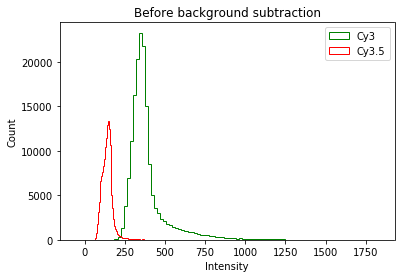

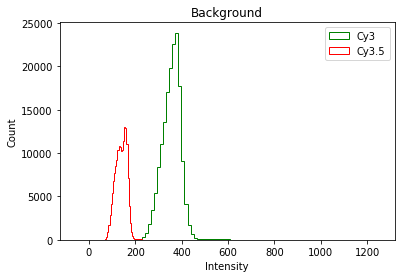

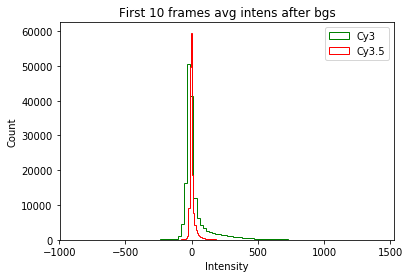

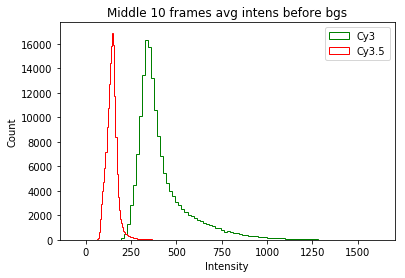

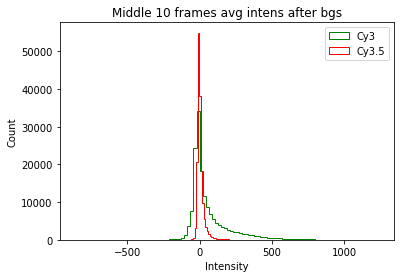

In [52]:
plt.figure()
for i in [0, 2]:
    avg_intens_i = avg_intens.T[i]
    min_i = min(avg_intens_i)
    max_i = max(avg_intens_i)
    plt.hist(avg_intens_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title("Before background subtraction")
plt.legend(lasers)
plt.savefig(sample_prefix + '_intensity_hist.png', dpi=200)


plt.figure()
for i in [0, 2]:
    bg_i = bg.T[i]
    min_i = min(bg_i)
    max_i = max(bg_i)
    plt.hist(bg_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title("Background")
plt.legend(lasers)
plt.savefig(sample_prefix + "_background_hist.png", dpi=200)

plt.figure()
for i in [0, 2]:
    color_i = avg_intens_bgs.T[i]
    min_i = min(color_i)
    max_i = max(color_i)
    plt.hist(color_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title("First 10 frames avg intens after bgs")
plt.legend(lasers)
plt.savefig(sample_prefix + '_intensity_hist_after_bgs.png', dpi=200)

plt.figure()
for i in [0, 2]:
    color_i = avg_intens_mid.T[i]
    min_i = min(color_i)
    max_i = max(color_i)
    plt.hist(color_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title("Middle 10 frames avg intens before bgs")
plt.legend(lasers)
plt.savefig(sample_prefix + '_intensity_hist_mid.png', dpi=200)

plt.figure()
for i in [0, 2]:
    color_i = avg_intens_bgs_mid.T[i]
    min_i = min(color_i)
    max_i = max(color_i)
    plt.hist(color_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title("Middle 10 frames avg intens after bgs")
plt.legend(lasers)
plt.savefig(sample_prefix + '_intensity_hist_after_bgs_mid.png', dpi=200)

# plt.figure()
# for i in [0, 2]:
#     color_i = avg_intens_bgs2.T[i]
#     min_i = min(color_i)
#     max_i = max(color_i)
#     plt.hist(color_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
# plt.xlabel('Intensity')
# plt.ylabel('Count')
# plt.title("First 10 frames avg intens after bgs")
# plt.legend(lasers)
# plt.savefig(sample_prefix + '_intensity_hist_after_bgs.png', dpi=200)

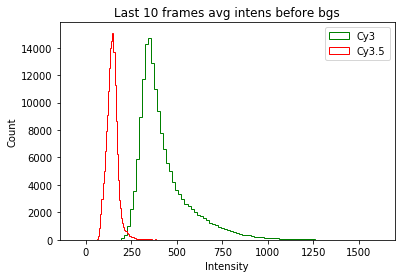

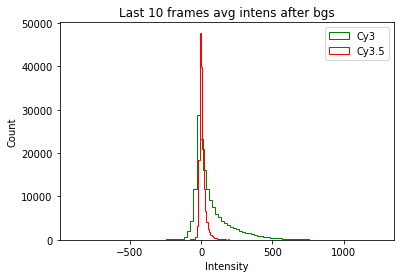

In [320]:
plt.figure()
for i in [0, 2]:
    color_i = avg_intens_last.T[i]
    min_i = min(color_i)
    max_i = max(color_i)
    plt.hist(color_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title("Last 10 frames avg intens before bgs")
plt.legend(lasers)
plt.savefig(sample_prefix + '_intensity_hist_last.png', dpi=200)

plt.figure()
for i in [0, 2]:
    color_i = avg_intens_bgs_last.T[i]
    min_i = min(color_i)
    max_i = max(color_i)
    plt.hist(color_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title("Last 10 frames avg intens after bgs")
plt.legend(lasers)
plt.savefig(sample_prefix + '_intensity_hist_after_bgs_last.png', dpi=200)

Raw data


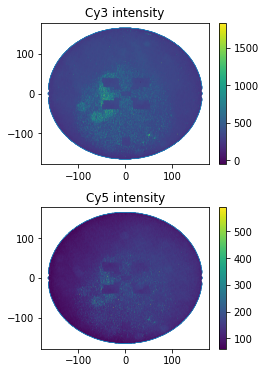

Background subtracted data


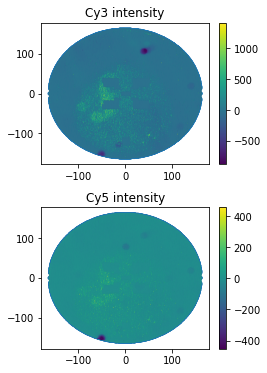

In [49]:
lasers = ['Cy3', 'Cy3.5', 'Cy5', 'Cy5.5']
print("Raw data")
plt.figure(figsize=(3.75, 6))
for i in [0, 2]:
    plt.subplot(2, 1, i/2+1)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, avg_intens.T[i])
    plt.title(lasers[i] + ' intensity')
    plt.colorbar()
plt.subplots_adjust(hspace=0.3)
plt.savefig(sample_prefix + '_grid.png')
plt.show()

print("Background subtracted data")
plt.figure(figsize=(3.75, 6))
for i in [0, 2]:
    plt.subplot(2, 1, i/2+1)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, avg_intens_bgs.T[i])
    plt.title(lasers[i] + ' intensity')
    plt.colorbar()
plt.subplots_adjust(hspace=0.3)
# plt.title("Before background subtraction")
plt.savefig(sample_prefix + '_grid_bgs.png')
plt.show()

5 min later raw intensity


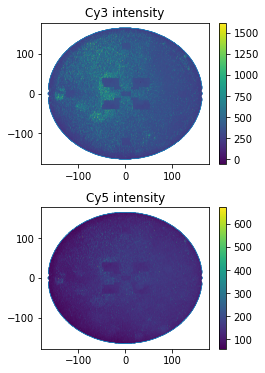

In [53]:
print("5 min later raw intensity")
plt.figure(figsize=(3.75, 6))
for i in [0, 2]:
    plt.subplot(2, 1, i/2+1)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, avg_intens_mid.T[i])
    plt.title(lasers[i] + ' intensity')
    plt.colorbar()
plt.subplots_adjust(hspace=0.3)
# plt.title("Before background subtraction")
plt.savefig(sample_prefix + '_grid_after_5min.png')
plt.show()

In [ ]:
print("5 min later raw intensity")
plt.figure(figsize=(3.75, 6))
for i in [0, 2]:
    plt.subplot(2, 1, i/2+1)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, avg_intens_mid.T[i])
    plt.title(lasers[i] + ' intensity')
    plt.colorbar()
plt.subplots_adjust(hspace=0.3)
# plt.title("Before background subtraction")
plt.savefig(sample_prefix + '_grid_after_5min.png')
plt.show()

## Filtering for wells that have desired intensity

In [318]:
channel = 0
low = 200
high = 500
sele_traces = []

for i in range(n_traces):
    if avg_intens_bgs[i, channel] > low and avg_intens_bgs[i, channel] < high:
        sele_traces.append(i)

print("%d traces have desired intensity." %len(sele_traces))

10928 traces have desired intensity.


In [ ]:
# display selected traces
count = 0
end_high = 500

for i in range(440, 450):
    traceID = sele_traces[i]
    last_10_frames = decode_array[raw_traces[traceID, channel, [end_frame-10, end_frame]]] - bg[traceID, channel]
    end_avg = np.mean(last_10_frames)
    if end_avg < end_high:
        plt.figure(figsize=(13,2))
        utils.decode_and_plot(time_axis, raw_traces, traceID, decode_array, colors, foi, bg, gamma, leakage, [0, 2], lasers)
        count += 1

print("Showing %d traces." %count)

In [ ]:
# count traces that bleached
count = 0
end_high = 20

for traceID in sele_traces:
    last_10_frames = decode_array[raw_traces[traceID, channel, [end_frame-10, end_frame]]] - bg[traceID, channel]
    end_avg = np.mean(last_10_frames)
    if end_avg < end_high:
        count += 1

print("%d traces satisfied constraints." %count)

In [ ]:
# randomly display selected traces
# count = 0
end_high = 500

for i in range(10):
    traceID = np.random.choice(sele_traces)
    last_10_frames = raw_traces[traceID, channel, [end_frame-10, end_frame]] - bg[traceID, channel]
    end_avg = np.mean(last_10_frames)
    if end_avg < end_high:
        plt.figure(figsize=(13,2))
        utils.decode_and_plot(time_axis, raw_traces, traceID, decode_array, colors, foi, bg, gamma, leakage, [0, 2], lasers)
#         count += 1

# print("Showing %d traces." %count)